# Predicting Bike Rentals

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
bike_rentals = pd.read_csv('https://raw.githubusercontent.com/itsjef/dataquest/master/bike_rental_hour.csv')

In [8]:
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 977.0)

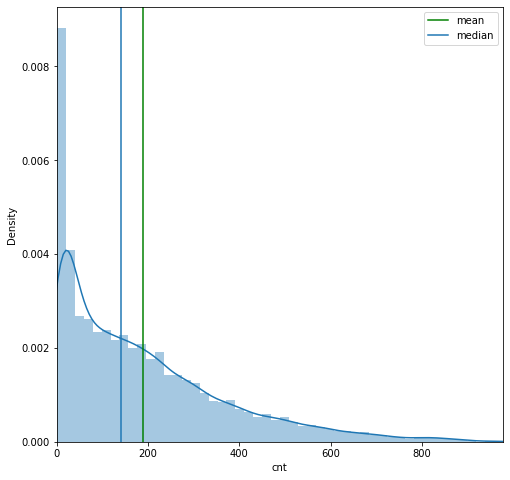

In [9]:
%matplotlib inline
plt.figure(figsize=(8,8))
sns.distplot(bike_rentals['cnt'],kde=True,rug=False)
plt.axvline(bike_rentals['cnt'].mean(),label='mean',color='green')
plt.axvline(bike_rentals['cnt'].median(),label='median')
plt.legend()
plt.xlim(0,bike_rentals['cnt'].max())

The distribution of the rentals is assymetric with the majority of values concentrated in the right proximity of 0. 

In [10]:
print(bike_rentals['cnt'].mean())
print(bike_rentals['cnt'].median())

189.46308763450142
142.0


Verifing how each feature correlates with the CNT target variable

In [11]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


There are no NaN entries in the data set (amem) 

Converting `dteday` column to date_time object

In [12]:
bike_rentals['dteday'] = pd.to_datetime(bike_rentals['dteday'])

Identifing correlations between target and features columns

In [13]:
correlations = bike_rentals.corr()['cnt']
correlation = correlations[abs(correlations.sort_values(ascending=False)) > 0.15]

In [14]:
correlation.drop(['casual','registered','cnt','instant','temp'])

season    0.178056
yr        0.250495
hr        0.394071
atemp     0.400929
hum      -0.322911
Name: cnt, dtype: float64

## Feature Engineering

Creating new features can improve models prediction. For instance, agreggating hours in day shifts like morning,evening,afternoon, is a way of telling the model that these sets belongs to the same group.

In [15]:
def hour_map(hour):
    if  6 < hour <=12:
        a = 1
    elif  12 < hour <= 18:
         a = 2
    elif 18 < hour <= 24:
        a = 3
    else:
        a = 4 
    return a

In [16]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(hour_map)

Dropping useless columns

In [17]:
bike_rentals = bike_rentals.drop(['dteday','casual','registered','instant'],axis=1)

# Picking a metric

Let's use a metric accordingly to the variable scale of measurement which is a numeric discrete variable. Both RMSE and MAE can be used. Let's do the analysis with the two. Generraly, the model is trained using the RMSE in regression or ANN. I dont know how it is in Tree based regressors.

# Splitting the Data Set

In [18]:
train = bike_rentals.sample(frac=.8,random_state = 2)

In [19]:
test = bike_rentals[~bike_rentals.index.isin(train.index)]

In [20]:
train.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
5943,3,0,9,4,0,6,0,1,0.58,0.5455,0.94,0.0896,7,4
15739,4,1,10,0,0,2,1,1,0.46,0.4545,0.88,0.1642,37,4
2906,2,0,5,0,0,5,1,1,0.44,0.4394,0.44,0.1642,56,4
12842,3,1,6,7,0,0,0,1,0.64,0.6061,0.69,0.1045,71,1
9053,1,1,1,3,0,3,1,2,0.44,0.4394,0.51,0.4925,4,4


In [21]:
target_label = ['cnt']
feature_label = train.drop(['cnt'],axis=1).columns.tolist() #Dropping the hour column

# Training a Linear Regressor

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [23]:
# Checking if features scaling is necessary
bike_rentals.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000


In [24]:
# Instantiating model and fitting
lr = LinearRegression()
lr.fit(train[feature_label],np.log(train[target_label]))

#Predictions
train_predictions = np.exp(lr.predict(train[feature_label]))
test_predictions =  np.exp(lr.predict(test[feature_label]))

#Metrics
#Train
train_mae = mean_absolute_error(train[target_label],train_predictions)
train_rmse = mean_squared_error(train[target_label],train_predictions)**.5
#Test
test_mae = mean_absolute_error(test[target_label],test_predictions)
test_rmse = mean_squared_error(test[target_label],test_predictions)**.5

print('train metrics')
print('MAE:',train_mae,'RMSE:',train_rmse)
print('\n')
print('test metrics')
print('MAE:',test_mae,'RMSE:',test_rmse)

train metrics
MAE: 88.69504477455492 RMSE: 134.52148530119547


test metrics
MAE: 85.86406113826892 RMSE: 130.5672679002007


In [25]:
#Checking error distribution
error = np.array(train[target_label]) - train_predictions

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


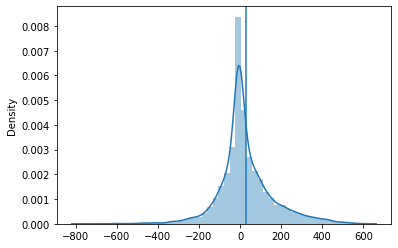

In [26]:
sns.distplot(error)
plt.axvline(np.mean(error))

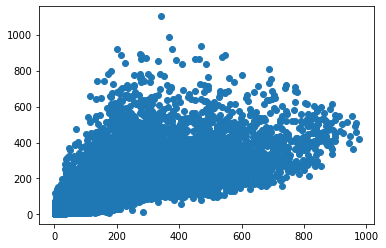

In [27]:
plt.scatter(np.array(train[target_label]),train_predictions)

The predictions are quite off for small values of the target column. In values closes to zero, it predicts negative values which is totally unreasonable

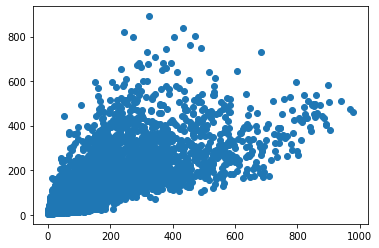

In [28]:
plt.scatter(np.array(test[target_label]),test_predictions)

# Building a Decision Tree and Random Forest Model

## Decision Tree

In [29]:
from sklearn.tree import DecisionTreeRegressor
metrics = []

In [30]:

def train_dec_tree():
    for leaf_sample in np.arange(1,101,5):
        dtr = DecisionTreeRegressor(criterion='mse',
                                    min_samples_leaf = leaf_sample)
        dtr.fit(train[feature_label],train[target_label])
        train_prediction = dtr.predict(train[feature_label])
        test_prediction = dtr.predict(test[feature_label])
        train_rmse = mean_squared_error(train[target_label],train_prediction)**.5
        test_rmse = mean_squared_error(test[target_label],test_prediction)**.5
        metrics.append([leaf_sample,train_rmse,test_rmse])

In [31]:
train_dec_tree()

In [32]:
metric = np.array(metrics)
metric

array([[ 1.        ,  0.54536027, 58.46944802],
       [ 6.        , 37.53542636, 52.51658727],
       [11.        , 45.3589412 , 53.97656313],
       [16.        , 49.30660703, 54.68209115],
       [21.        , 53.58074293, 56.4102318 ],
       [26.        , 54.5011792 , 57.14358205],
       [31.        , 56.2366    , 57.80553503],
       [36.        , 57.35048105, 58.67511975],
       [41.        , 60.37869568, 61.00024871],
       [46.        , 61.9051948 , 62.71578424],
       [51.        , 67.18965766, 66.64591391],
       [56.        , 67.97888159, 67.30998078],
       [61.        , 68.74605877, 68.42484842],
       [66.        , 69.66155721, 69.30079279],
       [71.        , 71.44106085, 71.91764647],
       [76.        , 72.64130216, 72.51922519],
       [81.        , 73.81833365, 74.69275354],
       [86.        , 75.69607363, 76.99473917],
       [91.        , 76.91915341, 78.11061634],
       [96.        , 77.69914193, 79.49903044]])

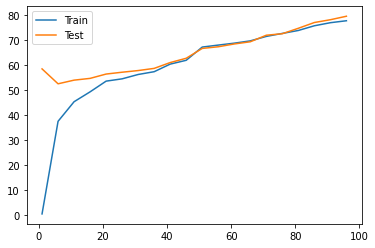

In [33]:
plt.plot(metric[:,0],metric[:,1],label='Train')
plt.plot(metric[:,0],metric[:,2],label='Test')
plt.legend()

41 seems the best number of minimum leaf samples to prevent overfitting. It have a similar metric for training and test (60)

Let's retrain a model with this parameter

In [34]:
dtr2 = DecisionTreeRegressor(criterion='mse',
                            min_samples_leaf = 41)
dtr2.fit(train[feature_label],train[target_label])
train_prediction2 = dtr2.predict(train[feature_label])
test_prediction2 = dtr2.predict(test[feature_label])
train_rmse_best = mean_squared_error(train[target_label],train_prediction2)**.5
test_rmse_best = mean_squared_error(test[target_label],test_prediction2)**.5
print('train rmse:',train_rmse_best,'test rmse',test_rmse_best)

train rmse: 60.378695676148084 test rmse 60.99818219390048


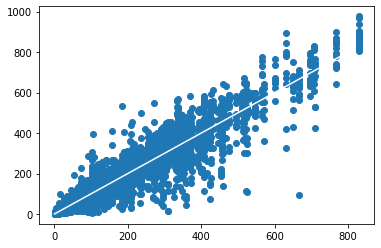

In [35]:

plt.scatter(test_prediction2,test[target_label])
plt.plot(np.arange(1,800,10),np.arange(1,800,10),color='white')

In [36]:
error_dtre = test_prediction2 - np.array(test[target_label])

## Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor   

In [38]:
def rand_forest():
    rf = RandomForestRegressor(n_estimators = 20, min_samples_leaf = 30)
    rf.fit(train[feature_label],train['cnt'])
    train_prediction = rf.predict(train[feature_label])
    test_prediction = rf.predict(test[feature_label])
    train_rmse = mean_squared_error(train['cnt'],train_prediction)**.5
    test_rmse = mean_squared_error(test['cnt'],test_prediction)**.5
    return (train_rmse,test_rmse)

In [39]:
rf_train,rf_test = rand_forest()

In [40]:
rf_train,rf_test

(57.026288487475455, 57.994779839950525)